In [140]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
import joblib

In [141]:
df = pd.read_csv("Loan Approval Dataset.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [142]:
df.drop("Loan_ID", axis=1, inplace=True)

In [143]:
df = df[df["Loan_Status"].notna()]

In [144]:
df["Loan_Status"] = df["Loan_Status"].map({'Y': 1, 'N': 0})

In [145]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

C:\Users\sagar\AppData\Local\Temp\ipykernel_20448\1113503720.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
C:\Users\sagar\AppData\Local\Temp\ipykernel_20448\1113503720.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [146]:
cat_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents']
encoders = {}

for col in cat_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()  # ✅ normalize
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

In [147]:
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

d:\new_summer_project\loan_env\lib\site-packages\xgboost\training.py:183: UserWarning: [02:16:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [152]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8481675392670157
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        66
           1       0.86      0.92      0.89       125

    accuracy                           0.85       191
   macro avg       0.84      0.82      0.83       191
weighted avg       0.85      0.85      0.85       191



In [153]:
explainer = shap.TreeExplainer(model, X_train)
shap_values = explainer(X_test)

In [154]:
shap.initjs()

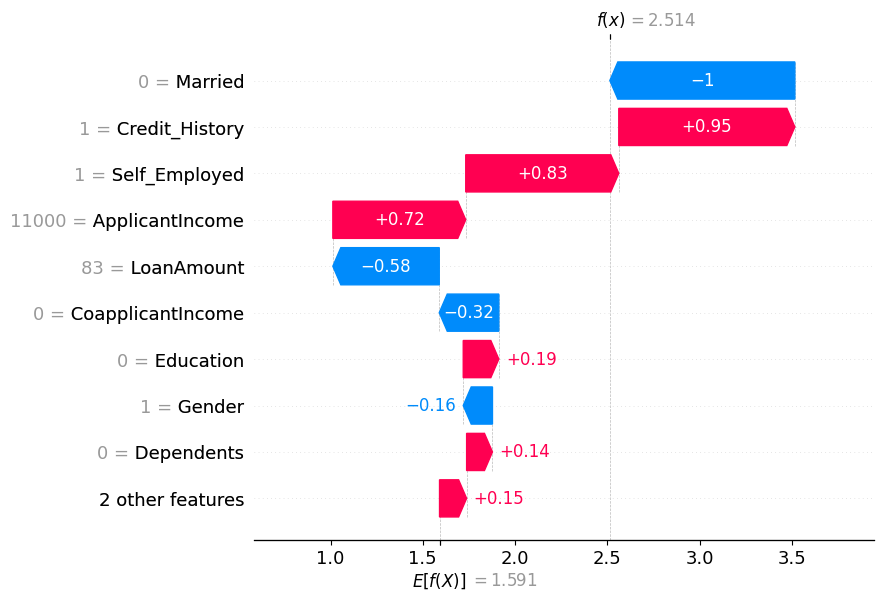

In [155]:
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=X_test.iloc[0],
    feature_names=X_test.columns.tolist()
))

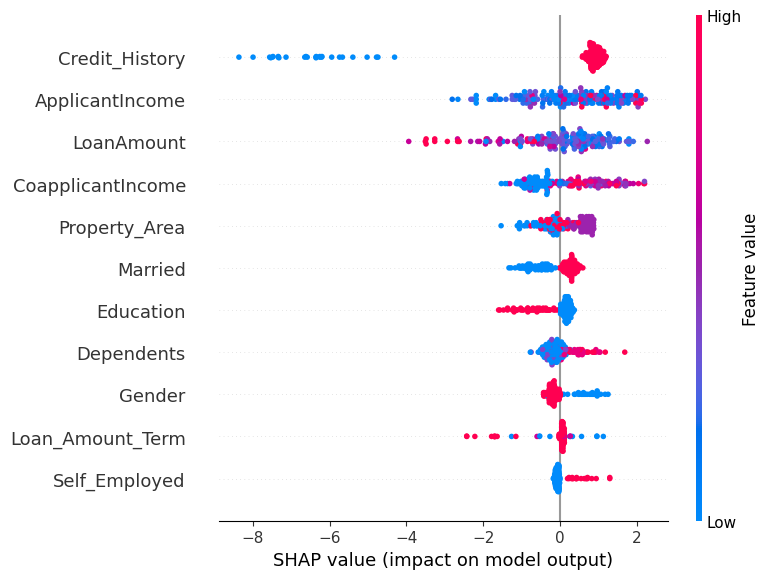

In [156]:
shap.summary_plot(shap_values, X_test)

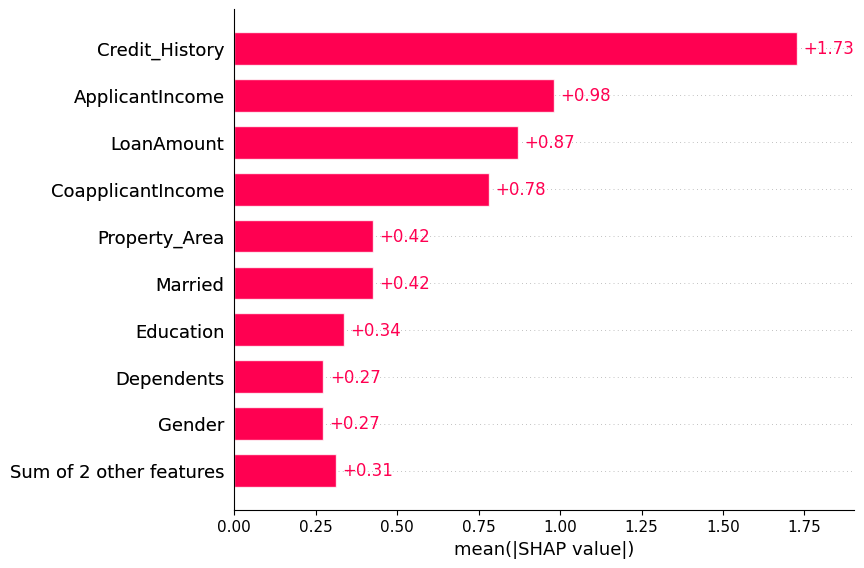

In [157]:
# optional

shap.plots.bar(shap_values)

In [164]:
expected_columns = X_train.columns.tolist()

In [165]:
os.makedirs("model", exist_ok=True)

joblib.dump(model, "models/xgb_model.pkl")
joblib.dump(encoders, "models/encoders.pkl")
joblib.dump(expected_columns, "models/expected_columns.pkl")

print("Model and encoder saved successfully.")

Model and encoder saved successfully.


In [162]:
model = joblib.load("models/xgb_model.pkl")
encoder = joblib.load("models/encoders.pkl")

In [163]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.71      0.76        66
           1       0.86      0.92      0.89       125

    accuracy                           0.85       191
   macro avg       0.84      0.82      0.83       191
weighted avg       0.85      0.85      0.85       191

[[ 47  19]
 [ 10 115]]


: 